# XENON Compression Solution Analysis

Sam Li, Rice AstroParticle Lab

Aug 15, 2020

In this notebook we are going to see all the avaliable compression solutions for XENON data. Given giant amout of data (PBs) we have to deal with, effectively reducing the size of data in storage is curcial for us. Down below we will examine lostless compression algorithms first, then compression using hard thresholding, and finally to Compressive Sensing if possible. 

# 1. Lostless Compression

In strax, there are already four existing compression solutions, namely ztsd, blosc and lz4. Beyond that, we are also going to look at LZMA and zlib compression, and perform speed & performance analysis on all of them. 

In [27]:
import lzma
import numpy as np
import matplotlib.pyplot as plt
import sys
import struct

In [28]:
import strax
import straxen
import blosc
import zlib
import zstd

In [29]:
#Load the data
st = straxen.contexts.xenon1t_dali()
rr = st.get_array('180215_1029','raw_records', seconds_range=(0, 5))

#Using seconds range 0-1 to ensure we have enough large samples

In [30]:
#Processing
r = strax.raw_to_records(rr)
strax.baseline(r)

In [31]:
#Let's also take a look at the datatype of records
records = r
np.save("records.npy", records)
dtype = records.dtype

for name in dtype.names:
    print(name)
    print(dtype.fields[name])

print('total bytes: %d' % dtype.itemsize)
print('header bytes: %d' % (dtype.itemsize - len(records[0][-1].tobytes())))
print('data bytes: %d' % len(records[0][-1].tobytes()))

time
(dtype('int64'), 0, 'Start time since unix epoch [ns]')
length
(dtype('int32'), 8, 'Length of the interval in samples')
dt
(dtype('int16'), 12, 'Width of one sample [ns]')
channel
(dtype('int16'), 14, 'Channel/PMT number')
pulse_length
(dtype('int32'), 16, 'Length of pulse to which the record belongs (without zero-padding)')
record_i
(dtype('int16'), 20, 'Fragment number in the pulse')
area
(dtype('int32'), 22, 'Integral in ADC counts x samples')
reduction_level
(dtype('uint8'), 26, 'Level of data reduction applied (strax.ReductionLevel enum)')
baseline
(dtype('float32'), 27, 'Baseline in ADC counts. data = int(baseline) - data_orig')
baseline_rms
(dtype('float32'), 31, 'Baseline RMS in ADC counts. data = baseline - data_orig')
amplitude_bit_shift
(dtype('int16'), 35, 'Multiply data by 2**(this number). Baseline is unaffected.')
data
(dtype(('<i2', (110,))), 37, 'Waveform data in raw counts above integer part of baseline')
total bytes: 257
header bytes: 37
data bytes: 220


# 1.1 LZMA Compression

Okay, now let's do some real compression. The first library we are going to use is LZMA. Since the header portion of a sample (fields contains information such as time, channel etc.) is different from the data field of the sample (110 length array), we initally thought it might be a good idea to seperate and compress them seperately. Let's see the outcomes. 

In [82]:
all_data = []
for record in records:
    # ignore trailing zeros
    data = record[-1][:record[1]]
    all_data.append(data)
    
#print (all_data)
print('LZMA compression (%d records):' % len(records))
ravel_data = np.concatenate(all_data)
lzma_ravel_data = lzma.compress(ravel_data.tobytes())

print (len(lzma_ravel_data) / len(ravel_data.tobytes()))

print('LZMA compression ratio (approx) for header:')
lzma_records = lzma.compress(records.tobytes())
print ((len(lzma_records) - len(lzma_ravel_data)) / (len(records.tobytes()) - len(ravel_data.tobytes())))

LZMA compression (627699 records):
0.2587785252446309
LZMA compression ratio (approx) for header:
0.2177556486447502


It seems for shorter datatypes (headers), the compression ratio is higher. However the compression ratios are not largely different. Moreover, if we seperate the data and header apart from a sample, recovering it will be harder after decompression; and if records is large enough, we might end up using extra computation resources. Therefore, for the rest of this notebook, we will compress records as a whole. 

In [15]:
%%time
compressed = lzma.compress(records)

CPU times: user 1min 47s, sys: 247 ms, total: 1min 47s
Wall time: 1min 47s


In [16]:
print (len(compressed))
print (len(records.tobytes()))
print (len(compressed)/float(len(records.tobytes())))

40032276
161318643
0.24815653823718317


It took 107 seconds for LZMA to compress a 161318643 Bytes (161 MB) Numpy Array, therefore we have the following statistics for LMZA:

In [17]:
print ("Compression Ratio: " + str(float(len(records.tobytes()))/len(compressed)) + "x")
print ("Compression Speed: " + str(161318643/107e6) + " MB/Second")

Compression Ratio: 4.0297144983712645x
Compression Speed: 1.5076508691588786 MB/Second


In [18]:
%%time
#Decompression is easy:
recovered_bytes= lzma.decompress(compressed)
decompressed = np.frombuffer(recovered_bytes, dtype=records.dtype)
print (decompressed[0])

(1518690592000028370, 102, 10, 96, 102, 0, 0, 0, 16001.725, 2.2134533, 0, [ 2,  0,  2,  2,  1, -1,  0, -5, -5, -6, -2, -5, -3, -3, -1,  0,  4,  1, -1, -2,  2,  2,  2, -1, -2, -2, -1, -3, -2, -1,  0, -2, -1,  0,  1,  0,  0, -1,  2,  0, -1, -3,  0, -2,  0, -4, -1, -2,  0, -2, 92, 53, 16,  7,  5,  5,  8,  3,  4, -1, -2,  2,  1,  1, -1,  0, -2, -2,  0,  0,  2, -1, -1, -2,  1, -2, -2, -3, -2, -1, -2, -3, -4, -5, -3, -3,  0, -4, -1, -3,  0,  0,  2, -1, -1, -3, -2, -3, -1, -3, -2, -3,  0,  0,  0,  0,  0,  0,  0,  0])
CPU times: user 2.09 s, sys: 92 ms, total: 2.19 s
Wall time: 2.19 s


Hence, we also obtained the following statistics for LZMA:

In [19]:
print ("Decompression Speed: " + str(40032276/2.09e6) + " MB/Second")

Decompression Speed: 19.1541990430622 MB/Second


Now let's try some other compression methods:

# 1.2 Blosc Compression

In [25]:
%%time
blosc_compressed = blosc.compress(records)
print ("Compression Ratio: " + str(float(161318643)/len(blosc_compressed)) + "x")

Compression Ratio: 1.4821795444271713x
CPU times: user 1.12 s, sys: 48 ms, total: 1.17 s
Wall time: 303 ms


In [26]:
print ("Compression Speed: " + str(161318643/1.12e6) + " MB/Second")

Compression Speed: 144.03450267857144 MB/Second


In [23]:
%%time
blosc_decompressed = blosc.decompress(blosc_compressed)

CPU times: user 641 ms, sys: 88 ms, total: 729 ms
Wall time: 195 ms


In [24]:
print ("Decompression Speed: " + str(len(blosc_compressed)/0.641e6) + " MB/Second")

Decompression Speed: 169.7953198127925 MB/Second


# 1.3 ZLIB Compression

In [28]:
%%time
zlib_compressed = zlib.compress(records)
print ("Compression Ratio: " + str(float(161318643)/len(zlib_compressed)) + "x")

Compression Ratio: 3.14336746418953x
CPU times: user 10.8 s, sys: 68.1 ms, total: 10.8 s
Wall time: 10.8 s


In [29]:
print ("Compression Speed: " + str(161318643/10.8e6) + " MB/Second")

Compression Speed: 14.93691138888889 MB/Second


In [30]:
%%time
zlib_decompressed = zlib.decompress(zlib_compressed)

CPU times: user 575 ms, sys: 84 ms, total: 659 ms
Wall time: 657 ms


In [31]:
print ("Decompression Speed: " + str(len(zlib_compressed)/0.575e6) + " MB/Second")

Decompression Speed: 89.25274086956522 MB/Second


# 1.4 lz4 Compression

In [36]:
%%time
import lz4
lz4_compressed = lz4.frame.compress(records)
print ("Compression Ratio: " + str(float(161318643)/len(lz4_compressed)) + "x")

Compression Ratio: 2.0344878993740783x
CPU times: user 567 ms, sys: 84 ms, total: 651 ms
Wall time: 648 ms


In [37]:
print ("Compression Speed: " + str(161318643/0.567e6) + " MB/Second")

Compression Speed: 284.5125978835979 MB/Second


In [38]:
%%time
lz4_decompressed = lz4.frame.decompress(lz4_compressed)

CPU times: user 159 ms, sys: 192 ms, total: 351 ms
Wall time: 347 ms


In [39]:
print ("Decompression Speed: " + str(len(lz4_compressed)/0.159e6) + " MB/Second")

Decompression Speed: 498.69191194968556 MB/Second


# 1.5 Zstd Compression

In [42]:
%%time
zstd_compressed = zstd.compress(records)
print ("Compression Ratio: " + str(float(161318643)/len(zstd_compressed)) + "x")

Compression Ratio: 3.255538973217942x
CPU times: user 1.7 s, sys: 228 ms, total: 1.93 s
Wall time: 180 ms


<timed exec>:1: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats


In [43]:
print ("Compression Speed: " + str(161318643/1.7e6) + " MB/Second")

Compression Speed: 94.89331941176471 MB/Second


In [44]:
%%time
zstd_decompressed = zstd.decompress(zstd_compressed)

<timed exec>:1: DeprecationWarning: PY_SSIZE_T_CLEAN will be required for '#' formats


CPU times: user 263 ms, sys: 76 ms, total: 339 ms
Wall time: 336 ms


In [46]:
print ("Decompression Speed: " + str(len(zstd_compressed)/0.263e6) + " MB/Second")

Decompression Speed: 188.41085171102662 MB/Second


# 1.6 gzip Compression

In [52]:
import timeit
start_time = timeit.default_timer()
import gzip
f = gzip.GzipFile("records.gz", "w")
np.save(file=f, arr=records)
f.close()
elapsed = timeit.default_timer() - start_time

In [57]:
print (elapsed)
def getSize(fileobject):
    fileobject.seek(0,2) # move the cursor to the end of the file
    size = fileobject.tell()
    return size

file = open('records.gz', 'rb')

print ("Compression Ratio: " + str(float(161318643)/getSize(file)) + "x")
print ("Compression Speed: " + str(161318643.0/(elapsed*1e6)) + " MB/Second")

64.92587907798588
Compression Ratio: 3.1672920314742576x
Compression Speed: 2.4846585874675906 MB/Second


# 1.7 Summary

In [13]:
compression_ratios = [4.0297144983712645, 1.4821795444271713, 3.14336746418953, 
                      2.0344878993740783, 3.255538973217942, 3.1672920314742576, 2.02]
compression_speeds = [1.5076508691588786,144.03450267857144,14.93691138888889, 
                     284.5125978835979,94.89331941176471,2.4846585874675906, 337]
names = ["LZMA", "blosc", "ZLIB", "lz4", "zstd", "gzip", "snappy"]

# We also tested out snappy, a high-speed compressor by Google writeen in C++. Running snappy requires gcc
# complier, which is missing on fried.rice.edu. Therefore we ran and evaluated it locally and added the 
# results above. 

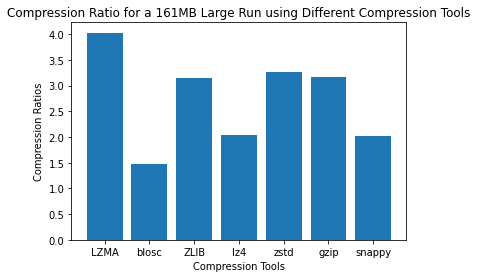

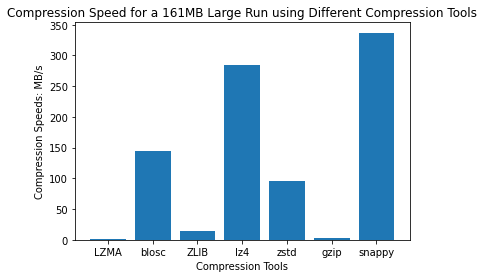

In [14]:
plt.bar(names, height=compression_ratios)
plt.title("Compression Ratio for a 161MB Large Run using Different Compression Tools")
plt.xlabel("Compression Tools")
plt.ylabel("Compression Ratios")
plt.show()

plt.bar(names, height=compression_speeds)
plt.title("Compression Speed for a 161MB Large Run using Different Compression Tools")
plt.xlabel("Compression Tools")
plt.ylabel("Compression Speeds: MB/s")
plt.show()

Therefore, as we can see above, LZMA has the highest lostless compression rate, while having the slowest compression speed; Gzip has slighly lower compression rate, and similar speed to LZMA. ZLIB and zstd have similar compression ratio as Gzip, while ZLIB is 10x faster and zstd is 100x faster. Finally blosc and lz4 are ~200x faster than LZMA, but are only able to compress down to 50%-60% of original size. 

In conclusion, LMZA provides max data size reduction and requires longer runtime. On average ZLIB and zstd are better options with moderate speed. To pursue maximum processing speed, one should consider snappy. 

# 2. Hardthresholded Compression

In the section above, we have discussed about loseless compression. But when examining out data, it's easy to see that most of our data is compressed of noises (less than 30 ADC counts). In other words, all legal pulses exist with a min ADC value of 30. Therefore, if we keep the +/- 5 values around that "peak", while eliminating all other values, we could further reduce the size of the data on disk. 

In [32]:
hth = records.copy()
total_length = 0
for sample in hth:
    arr = sample[-1]
    new_arr = []
    for i in range(110):
        if arr[i] >= 30:
            new_arr += list(arr[i-5:i+5])
    total_length += len(new_arr)
    
print (total_length)

42059077


In [33]:
print (42059077/161318643)

0.2607204983741402


The data above shows that only 26% of the data is useful -- in other words, pulse. Therefore we might want to re-calculate the compression ratio we can achieve: with hard-thresholding and loseless compression. 

In [35]:
compression_ratios_old = [4.0297144983712645, 1.4821795444271713, 3.14336746418953, 
                      2.0344878993740783, 3.255538973217942, 3.1672920314742576, 2.02]
cr_new = []
for item in compression_ratios_old:
    cr_new.append(item/0.2607204983741402)
print (cr_new)

[15.456070863245003, 5.684936756680359, 12.056464619359241, 7.803329281975134, 12.486701251031537, 12.148227896255083, 7.7477605811463715]


In [50]:
percentage = []
for item in cr_new:
    percentage.append(round(100/item, 2))
print (percentage)

[6.47, 17.59, 8.29, 12.82, 8.01, 8.23, 12.91]


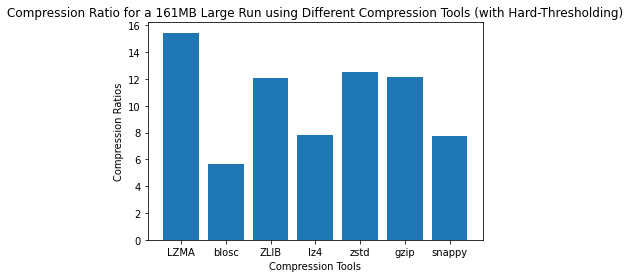

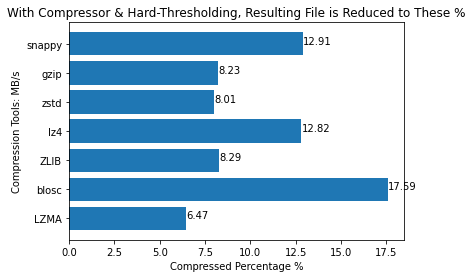

In [55]:
plt.bar(names, height=cr_new)
plt.title("Compression Ratio for a 161MB Large Run using Different Compression Tools (with Hard-Thresholding)")
plt.xlabel("Compression Tools")
plt.ylabel("Compression Ratios")
plt.show()

plt.barh(names, percentage)
plt.title("With Compressor & Hard-Thresholding, Resulting File is Reduced to These %")
plt.xlabel("Compressed Percentage %")
plt.ylabel("Compression Tools: MB/s")
for index, value in enumerate(percentage):
    plt.text(value, index, str(value))
plt.show()

As we can see above, on average we can get the sample down to 10% of its original size. This is a big improvement. 